In [1]:
import warnings
import os
import sys
# try to import peal and if not installed, add the parent directory to the path
try:
    import peal

except ImportError:
    # if peal not installed, but project downloaded locally
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# import basic libraries needed for sure and set the device depending on whether cuda is available or not
import torch
from peal.utils import request
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings('ignore')

# set autoreload for more convinient development
%load_ext autoreload
%autoreload 2

# check and set that the right gpu is used
if device == 'cuda':
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    !nvidia-smi
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('Currently used device: ' + str(os.environ["CUDA_VISIBLE_DEVICES"]))
    os.environ["CUDA_VISIBLE_DEVICES"] = request(
        'cuda_visible_devices', default="0")
    torch.cuda.set_device(int(os.environ["CUDA_VISIBLE_DEVICES"]))
    import math
    import nvidia_smi
    nvidia_smi.nvmlInit()
    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
    gigabyte_vram = info.total / math.pow(10, 9)
    print("Total memory:", gigabyte_vram)

else:
    gigabyte_vram = None


In [2]:
# create the datasets
from peal.data.dataset_factory import get_datasets
from peal.data.dataset_generators import CircleDatasetGenerator
from peal.utils import load_yaml_config
import copy

unpoisened_dataset_config = load_yaml_config('$PEAL/configs/data/symbolic_circle.yaml')
unpoisened_dataset_config['num_samples'] = 500
unpoisened_dataset_config['noise_scale'] = 0
unpoisened_dataset_config["set_negative_to_zero"] = False
dg = CircleDatasetGenerator(
    dataset_name='circle',
    num_samples=unpoisened_dataset_config['num_samples'],
    radius=unpoisened_dataset_config['radius'],
    noise_scale=unpoisened_dataset_config['noise_scale'],
    seed=unpoisened_dataset_config['seed'],
)

dg.generate_dataset()

student_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_classifier.yaml')
if len(student_config['task']['x_selection']):
    unpoisened_dataset_config['input_size'] = [len(student_config['task']['x_selection'])]
    
unpoisened_dataset_train, unpoisened_dataset_val, unpoisened_dataset_test = get_datasets(
    config=unpoisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config['task'],
)

# create a copy of the dataset config that will be poisened in the next steps
poisened_dataset_config = copy.deepcopy(unpoisened_dataset_config)
poisened_dataset_config['num_samples'] = int(unpoisened_dataset_config['num_samples'] / 2)

confounder_probability = request('confounder_probability', '100')
poisened_dataset_config['confounder_probability'] = float(confounder_probability) / 100

# create dataset based changed data config
poisened_dataset_train, poisened_dataset_val, poisened_dataset_test = get_datasets(
    config=poisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config['task'],
)

pygame 2.1.2 (SDL 2.0.16, Python 3.9.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


Do you want to change value of confounder_probability? [y/n] n


In [3]:
is_train_generator = request('is_train_generator', False)
if is_train_generator:
    # if you want the generator getting trained from scratch
    from peal.generators.variational_autoencoders import VAE
    from peal.training.trainers import ModelTrainer
    from peal.data.dataset_wrappers import VAEDatasetWrapper
    generator_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_vae.yaml')
    generator_config['data'] = unpoisened_dataset_train.config
    generator_config['training']['max_epochs'] = 5
    generator = VAE(generator_config).to(device)

    dataset_train = VAEDatasetWrapper(unpoisened_dataset_train)
    dataset_val = VAEDatasetWrapper(unpoisened_dataset_val)

    generator_trainer = ModelTrainer(
        config=generator_config,
        model=generator,
        datasource=(dataset_train, dataset_val),
        model_name=request(
            'generator_model_name',
            'artificial_symbolic_' + confounder_probability + '_generator'
        ),
        gigabyte_vram=gigabyte_vram
    )
    generator_trainer.fit()

else:
    # if you want to use loaded generator
    generator_path = request(
        'generator_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_generator/model.cpl'
    )
    generator = torch.load(generator_path).to(device)


Do you want to change value of is_train_generator? [y/n] n
Do you want to change value of generator_path? [y/n] n


In [4]:
is_train_student = request('is_train_student', False)
if is_train_student:
    # if you want to train your own initial student model
    from peal.architectures.downstream_models import Symbolic2VectorModel
    from peal.training.trainers import ModelTrainer
    student_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_classifier.yaml')
    student_config['data'] = poisened_dataset_train.config
    student_config['training']['max_epochs'] = 5 
    # create and traing student model
    student = Symbolic2VectorModel(student_config).to(device)
    student_trainer = ModelTrainer(
        config=student_config,
        model=student,
        datasource=(poisened_dataset_train, poisened_dataset_val),
        model_name=request(
            'student_model_name',
            'artificial_symbolic_' + confounder_probability + '_classifier'
        ),
        gigabyte_vram=gigabyte_vram
    )
    student_trainer.fit()

else:
    # if you want to load your initial student model
    student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/model.cpl'
    )
    student = torch.load(student_path).to(device)


Do you want to change value of is_train_student? [y/n] n
Do you want to change value of student_path? [y/n] n


In [5]:
teacher_type = request('teacher_type', 'load') # changes this to load
if teacher_type == 'train':
    # if you want to train and use new model for knowledge distillation
    from peal.architectures.downstream_models import Symbolic2VectorModel
    from peal.training.trainers import ModelTrainer
    teacher_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_classifier.yaml')
    teacher_config['data'] = unpoisened_dataset_train.config
    teacher_config['training']['max_epochs'] = 5

    # create and train teacher model
    teacher = Symbolic2VectorModel(teacher_config).to(device)
    teacher_trainer = ModelTrainer(
        config=teacher_config,
        model=teacher,
        datasource=(unpoisened_dataset_train, unpoisened_dataset_val),
        model_name=request('teacher_model_name', 'artificial_symbolic_unpoisened_classifier'),
        gigabyte_vram=gigabyte_vram
    )
    teacher_trainer.fit()
    teacher_type = 'oracle'

elif teacher_type == 'load':
    # if you want to use existing model for knowledge distillation
    teacher_path = request(
        'teacher_path', 'peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')
    teacher = torch.load(teacher_path).to(device)
    teacher_type = 'oracle'

else:
    teacher = teacher_type

Do you want to change value of teacher_type? [y/n] n
Do you want to change value of teacher_path? [y/n] n


In [152]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
def plot_decision_boundary(model, dataset):
    assert isinstance(dataset, peal.data.datasets.SymbolicDataset)
    
    data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
    for idx, key in enumerate(dataset.data):
        data[idx] = dataset.data[key]
    
    input_idx = [idx for idx, element in enumerate(unpoisened_dataset_train.attributes) if element in unpoisened_dataset_train.task_config['x_selection']]
    target_idx = [idx for idx, element in enumerate(unpoisened_dataset_train.attributes) if element in unpoisened_dataset_train.task_config['y_selection']]
    confounder_idx =  [idx for idx, element in enumerate(unpoisened_dataset_train.attributes) if element in list(set(confounding) - set(unpoisened_dataset_train.task_config['y_selection']))]
    #if isinstance(data, torch.Tensor):
    #    data = data.numpy()
    #if isinstance(data, pd.DataFrame):
    #    data = data.to_numpy()
    #xmin, xmax = data[:,0].min()-1, data[:,0].max()+1
    #ymin, ymax = data[:,1].min()-1, data[:,1].max()+1
    
    steps = 1000
    #input_grid = []
    #x1_span = np.linspace(-1.5, 1.5, steps)
    #x2_span = np.linspace(-1.5, 1.5, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    xx1, xx2 = np.meshgrid(*[np.linspace(float(data[:, [input_idx]].min()-0.5),float(data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
    grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    #xx1, xx2 = np.meshgrid(*[np.linspace(int(data[:, 0].min())-0.5,int(data[:, 0].min())+0.5) for idx in input_idx])
    #grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    model.eval()
    z = model(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
    fig, ax = plt.subplots()
    #idx = features_idx+[class_label_idx]
    ax.scatter(data[:,0], data[:,1], c=data[:,target_idx])
    ax.contour(xx1, xx2, z, levels=[0],linestyles='dashed')
    ax.grid()

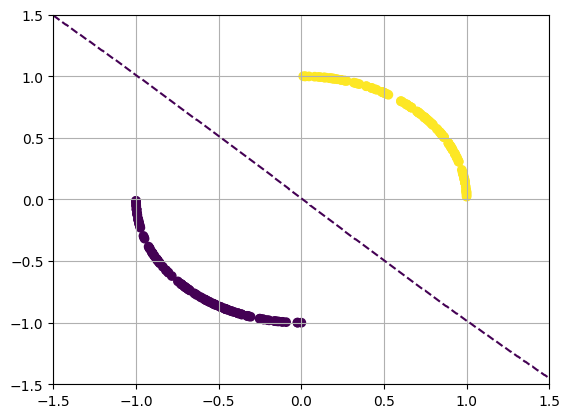

In [153]:
plot_decision_boundary(student, poisened_dataset_train)

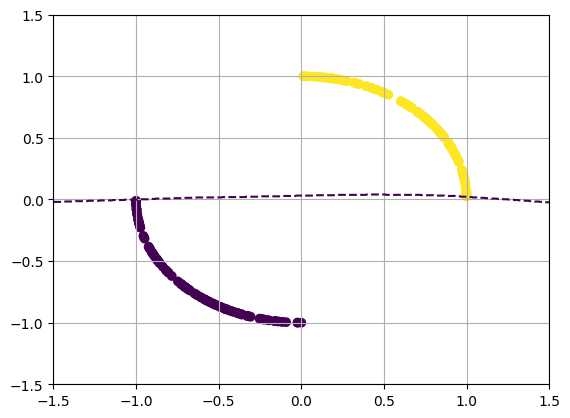

In [154]:
plot_decision_boundary(teacher, poisened_dataset_train)

In [6]:
# use counterfactual knowledge distillation to improve model
from peal.adaptors.counterfactual_knowledge_distillation import CounterfactualKnowledgeDistillation
cfkd = CounterfactualKnowledgeDistillation(
    student=student,
    datasource=(
        poisened_dataset_train,
        poisened_dataset_val,
        unpoisened_dataset_test,
    ),
    output_size=2,
    generator=generator,
    teacher=teacher,
    base_dir=request(
        'cfkd_base_dir',
        'peal_runs/artificial_symbolic_' + confounder_probability +
        '_classifier/cfkd_' + teacher_type
    ),
    gigabyte_vram=gigabyte_vram,
    overwrite=True,
)
cfkd.adaptor_config['explainer']['learning_rate'] = 1.0
cfkd.adaptor_config['explainer']['gradient_steps'] = 51
cfkd.run()

Do you want to change value of cfkd_base_dir? [y/n] n


{'batch_size': 1, 'num_batches': 2, 'gigabyte_vram': 40, 'max_train_samples': 2, 'assumed_input_size': [3, 64, 64], 'finetune_iterations': 5, 'current_iteration': 0, 'use_confusion_matrix': False, 'continuos_learning': False, 'mixing_ratio': 0.5, 'min_start_target_percentile': 0.0, 'attribution_threshold': 0.5, 'max_validation_samples': 2, 'replace_model': True, 'fa_1sided_prime': 0.0, 'replacement_strategy': 'direct', 'explainer': {'explanation_style': 'counterfactual', 'learning_rate': 0.001, 'gradient_steps': 31, 'optimizer': 'Adam', 'y_target_goal_confidence': 0.65, 'use_masking': True, 'img_noise_injection': 0.01, 'l1_regularization': 1.0, 'log_prob_regularization': 0.0, 'img_regularization': 0.0}, 'training': {'train_batch_size': 1, 'val_batch_size': 1, 'test_batch_size': 1, 'base_batch_size': 50, 'gigabyte_vram': 40, 'assumed_input_size': [3, 64, 64], 'max_epochs': 1, 'learning_rate': 0.0, 'optimizer': 'adam', 'global_train_step': 0, 'global_validation_step': 0, 'epoch': -1, 'it

Calculate Confusion Matrix: it: 0, current_accuracy: 1.0: : 0it [00:00, ?it/s]
  0%|                                                                                            | 0/51 [00:00<?, ?it/s]
Creating Counterfactuals: it: 0, loss: 8.728083610534668, target_confidences: [0.00016197256627492607], visual_differenc
Creating Counterfactuals: it: 1, loss: 1.0000423192977905, target_confidences: [0.9999569654464722], visual_difference: 
Calculate Confusion Matrix: it: 1, current_accuracy: 1.0: : 1it [00:00,  7.01it/s]
  0%|                                                                                            | 0/51 [00:00<?, ?it/s]
Creating Counterfactuals: it: 0, loss: 6.944846153259277, target_confidences: [0.0009635886526666582], visual_difference
Creating Counterfactuals: it: 1, loss: 1.0000052452087402, target_confidences: [0.9999945163726807], visual_difference: 
Calculate Confusion Matrix: it: 1, current_accuracy: 1.0: : 1it [00:00,  5.37it/s]
test_correct: 0.7884615384615


Epoch: 0


Model Training: train_it: 0, loss: 0.5927131175994873: : 1it [00:00, 33.02it/s]


epoch_train_loss_accumulated 0.5927131175994873
epoch_train_accuracy 1.0
epoch_train_predicted_classes: tensor([1., 0.])
epoch_train_targets: tensor([1., 0.])
epoch_train_classes_difference: tensor([0., 0.])



Model Training: validation_0_it: 23, loss: 0.5848121643066406: : 24it [00:00, 28.86it/s]



epoch_validation_0_loss_accumulated 0.6925186514854431
epoch_validation_0_accuracy 0.5
epoch_validation_0_predicted_classes: tensor([1., 0.])
epoch_validation_0_targets: tensor([0.5000, 0.5000])
epoch_validation_0_classes_difference: tensor([ 0.5000, -0.5000])


0it [00:00, ?it/s]



epoch_validation_1_loss_accumulated nan


RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [49]:
# NOTES:
# 1. When student is ran without generating data, confounder probability is not defined and, therefore, the logic of loading preexisting model fails (need to load data before, should be allowed to skip)
# 2. unclear about the folder structure for cfdk
# 3. 

In [ ]:
# for dataloaders.py    
    if isinstance(val_dataloader, torch.utils.data.dataloader.DataLoader):
        if len(val_dataloader.dataset.data[list(val_dataloader.dataset.data.keys())[-1]]) < 1:
            val_dataloader.dataset.data.popitem()


In [11]:
poisened_dataset_val.data

{'0': tensor([0.2402, 0.9707, 1.0000, 1.0000]),
 '1': tensor([0.9904, 0.1382, 1.0000, 1.0000]),
 '2': tensor([0.8900, 0.4560, 1.0000, 1.0000]),
 '3': tensor([0.8502, 0.5264, 1.0000, 1.0000]),
 '4': tensor([0.9983, 0.0577, 1.0000, 1.0000]),
 '5': tensor([0.0115, 0.9999, 1.0000, 1.0000]),
 '6': tensor([0.1951, 0.9808, 1.0000, 1.0000]),
 '7': tensor([0.6651, 0.7467, 1.0000, 1.0000]),
 '8': tensor([0.9760, 0.2177, 1.0000, 1.0000]),
 '9': tensor([0.9994, 0.0346, 1.0000, 1.0000]),
 '10': tensor([0.3933, 0.9194, 1.0000, 1.0000]),
 '11': tensor([0.3287, 0.9444, 1.0000, 1.0000]),
 '12': tensor([0.8378, 0.5459, 1.0000, 1.0000]),
 '13': tensor([0.6651, 0.7467, 1.0000, 1.0000]),
 '14': tensor([0.5166, 0.8562, 1.0000, 1.0000]),
 '15': tensor([0.9989, 0.0462, 1.0000, 1.0000]),
 '16': tensor([0.2625, 0.9649, 1.0000, 1.0000]),
 '17': tensor([0.9904, 0.1382, 1.0000, 1.0000]),
 '18': tensor([0.7839, 0.6209, 1.0000, 1.0000]),
 '19': tensor([0.0462, 0.9989, 1.0000, 1.0000]),
 '20': tensor([0.1951, 0.9808,

In [20]:
unpoisened_dataset_train.task_config

{'criterions': {'ce': 1.0, 'l1': 10000.0},
 'output_type': 'multiclass',
 'output_size': 2,
 'x_selection': ['x1', 'x2'],
 'y_selection': ['Target'],
 'selection': ['x1', 'x2']}